<a href="https://colab.research.google.com/github/writezubair-cpu/ZAK-TEST_AI_Training/blob/main/Copy_of_hydraulic_system_project_local_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import HTML

# Replace 'YOUR_VIDEO_ID' with the actual YouTube video ID


HTML(f'''<iframe width="560" height="315" src="https://www.youtube.com/embed/G0q5X7jDyCg?si=9kb9vsCllU5i9CRg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>''')

# Condition Monitoring of Hydraulic Systems – Colab Project (Local `data/` Folder)

This notebook assumes **all dataset files are already in a folder called `data/` in Google Colab**, for example:

- `data/PS1.txt`, `data/PS2.txt`, ..., `data/SE.txt`  
- `data/profile.txt` (targets)

We will:

1. Load sensor time-series files from `data/`  
2. Load condition labels from `profile.txt`  
3. Build **cycle-level summary features** (mean, std, min, max, etc.)  
4. Do basic **EDA**  
5. Train two ML models:
   - **Random Forest** (no learning rate)
   - **XGBoost** (with a **learning_rate** hyperparameter)
6. Inspect performance & feature importance (with SHAP)


## 1. Setup & Imports

Install and import required libraries.

> Make sure your working directory in Colab has a folder named `data/` that contains all the `.txt` files from the UCI hydraulic dataset.


In [ ]:
!pip install -q shap xgboost

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
import shap

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

DATA_DIR = "data"  # relative folder where all .txt files are stored

print("Setup complete. Looking for files in:", os.path.abspath(DATA_DIR))

Setup complete. Looking for files in: /content/data


## 2. Load Sensor Data from `data/`

The original dataset provides one **tab-delimited text file per sensor**.  
Typical filenames (you should have these in `data/`):

- `PS1.txt` … `PS6.txt` – pressure sensors  
- `EPS1.txt` – motor power  
- `FS1.txt`, `FS2.txt` – flow sensors  
- `TS1.txt` … `TS4.txt` – temperature sensors  
- `VS1.txt` – vibration  
- `CE.txt`, `CP.txt`, `SE.txt` – virtual / efficiency signals  

Each file:
- Rows = cycles (2205)  
- Columns = time points within the 60-second cycle  


In [ ]:
# Define expected sensor files
sensor_files = {
    "PS1": "PS1.txt",
    "PS2": "PS2.txt",
    "PS3": "PS3.txt",
    "PS4": "PS4.txt",
    "PS5": "PS5.txt",
    "PS6": "PS6.txt",
    "EPS1": "EPS1.txt",
    "FS1": "FS1.txt",
    "FS2": "FS2.txt",
    "TS1": "TS1.txt",
    "TS2": "TS2.txt",
    "TS3": "TS3.txt",
    "TS4": "TS4.txt",
    "VS1": "VS1.txt",
    "CE": "CE.txt",
    "CP": "CP.txt",
    "SE": "SE.txt",
}

def load_sensor_matrix(sensor_name, filename, data_dir=DATA_DIR):
    """Load a sensor .txt file (tab-delimited, no header) as DataFrame."""
    path = os.path.join(data_dir, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Please make sure it is in the data/ folder.")
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = [f"{sensor_name}_t{j}" for j in range(df.shape[1])]
    return df

# Load all sensors into a dict: name -> DataFrame
sensor_data = {}
for name, fname in sensor_files.items():
    print(f"Loading {name} from {fname}...")
    sensor_data[name] = load_sensor_matrix(name, fname)

# Check shapes (all should have same number of rows)
for name, df in sensor_data.items():
    print(f"{name}: shape = {df.shape}")

Loading PS1 from PS1.txt...
Loading PS2 from PS2.txt...
Loading PS3 from PS3.txt...
Loading PS4 from PS4.txt...
Loading PS5 from PS5.txt...
Loading PS6 from PS6.txt...
Loading EPS1 from EPS1.txt...
Loading FS1 from FS1.txt...
Loading FS2 from FS2.txt...
Loading TS1 from TS1.txt...
Loading TS2 from TS2.txt...
Loading TS3 from TS3.txt...
Loading TS4 from TS4.txt...
Loading VS1 from VS1.txt...
Loading CE from CE.txt...
Loading CP from CP.txt...
Loading SE from SE.txt...
PS1: shape = (2205, 6000)
PS2: shape = (2205, 6000)
PS3: shape = (2205, 6000)
PS4: shape = (2205, 6000)
PS5: shape = (2111, 6000)
PS6: shape = (1515, 6000)
EPS1: shape = (2205, 6000)
FS1: shape = (2205, 600)
FS2: shape = (2205, 600)
TS1: shape = (2205, 60)
TS2: shape = (2205, 60)
TS3: shape = (2205, 60)
TS4: shape = (2205, 60)
VS1: shape = (2205, 60)
CE: shape = (2205, 60)
CP: shape = (2205, 60)
SE: shape = (2205, 60)


## 3. Load Target Condition Labels from `profile.txt`

The file `profile.txt` (tab-delimited) contains cycle-wise condition labels:

1. Cooler condition (%): 3, 20, 100  
2. Valve condition (%): 100, 90, 80, 73  
3. Internal pump leakage: 0, 1, 2  
4. Hydraulic accumulator pressure (bar): 130, 115, 100, 90  
5. Stability flag: 0 (stable), 1 (not stable)


In [ ]:
profile_path = os.path.join(DATA_DIR, "profile.txt")
if not os.path.exists(profile_path):
    raise FileNotFoundError(f"Targets file not found: {profile_path}")

y = pd.read_csv(
    profile_path,
    sep="\t",
    header=None,
    names=["cooler_condition", "valve_condition", "pump_leakage", "accumulator_pressure", "stable_flag"],
)

print("Targets shape:", y.shape)
display(y.head())

# Basic distribution of targets
for col in y.columns:
    print(f"\n=== {col} ===")
    print(y[col].value_counts())

Targets shape: (2205, 5)


,cooler_condition,valve_condition,pump_leakage,accumulator_pressure,stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1



=== cooler_condition ===
cooler_condition
100    741
3      732
20     732
Name: count, dtype: int64

=== valve_condition ===
valve_condition
100    1125
73      360
80      360
90      360
Name: count, dtype: int64

=== pump_leakage ===
pump_leakage
0    1221
2     492
1     492
Name: count, dtype: int64

=== accumulator_pressure ===
accumulator_pressure
90     808
130    599
115    399
100    399
Name: count, dtype: int64

=== stable_flag ===
stable_flag
0    1449
1     756
Name: count, dtype: int64


In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   cooler_condition      2205 non-null   int64
 1   valve_condition       2205 non-null   int64
 2   pump_leakage          2205 non-null   int64
 3   accumulator_pressure  2205 non-null   int64
 4   stable_flag           2205 non-null   int64
dtypes: int64(5)
memory usage: 86.3 KB


## 4. From Raw Time-Series to Summary Features (`X_summary`)

For each sensor matrix (e.g., PS1), we compute **per-cycle summary features**:

- mean  
- standard deviation  
- min / max  
- median  
- 10th & 90th percentile  
- simple trend: `last_value − first_value`  

We then concatenate these summaries across all sensors to get a compact `X_summary`.


In [ ]:
def summarize_sensor_block(block_df, sensor_name):
    """Compute per-cycle summary stats for a sensor block (n_cycles × n_timepoints)."""
    arr = block_df.to_numpy()
    mean  = arr.mean(axis=1)
    std   = arr.std(axis=1)
    minv  = arr.min(axis=1)
    maxv  = arr.max(axis=1)
    med   = np.median(arr, axis=1)
    p10   = np.percentile(arr, 10, axis=1)
    p90   = np.percentile(arr, 90, axis=1)
    trend = arr[:, -1] - arr[:, 0]

    summary = pd.DataFrame({
        f"{sensor_name}_mean": mean,
        f"{sensor_name}_std": std,
        f"{sensor_name}_min": minv,
        f"{sensor_name}_max": maxv,
        f"{sensor_name}_median": med,
        f"{sensor_name}_p10": p10,
        f"{sensor_name}_p90": p90,
        f"{sensor_name}_trend": trend,
    })
    return summary

# Build X_summary by concatenating summaries of all sensors
summary_parts = []
for sensor_name, df_sensor in sensor_data.items():
    summary = summarize_sensor_block(df_sensor, sensor_name)
    summary_parts.append(summary)

X_summary = pd.concat(summary_parts, axis=1)
print("X_summary shape:", X_summary.shape)
display(X_summary.head())

X_summary shape: (2205, 136)


,PS1_mean,PS1_std,PS1_min,PS1_max,PS1_median,PS1_p10,PS1_p90,PS1_trend,PS2_mean,PS2_std,...,CP_p90,CP_trend,SE_mean,SE_std,SE_min,SE_max,SE_median,SE_p10,SE_p90,SE_trend
0,160.673492,13.938147,145.83,191.51,156.25,146.10,191.270,-0.28,109.466914,47.110581,...,2.1782,-0.801,59.157183,23.565119,0.0,79.568,68.5145,0.0,69.8248,0.225
1,160.603320,14.117791,145.73,191.47,156.06,146.09,191.240,-0.25,109.354890,47.041690,...,1.3640,-0.250,59.335617,23.658267,0.0,80.441,68.5360,0.0,70.2642,0.331
2,160.347720,14.191436,145.37,191.41,155.72,145.94,191.170,-0.19,109.158845,46.988144,...,1.1452,-0.056,59.543150,23.723181,0.0,80.824,68.8530,0.0,70.1115,0.033
3,160.188088,14.226617,145.14,191.34,155.56,145.81,191.111,-0.20,109.064807,46.968307,...,1.0971,-0.010,59.794900,23.821972,0.0,80.930,69.0060,0.0,70.6276,0.240
4,160.000472,14.275244,144.95,191.41,155.34,145.65,191.060,-0.22,108.931434,46.871040,...,1.0971,0.020,59.455267,23.771653,0.0,81.100,69.0130,0.0,70.6970,0.104


The `NameError` indicated that `sensor_data` was not defined. This typically means the cell that loads the sensor data (cell `f868c787`) was not executed. The following cell re-provides the code to define `sensor_data`.

## 5. Exploratory Data Analysis (EDA)

1. Plot **target distributions**  
2. Check **correlation** between features and the main target (`pump_leakage`)


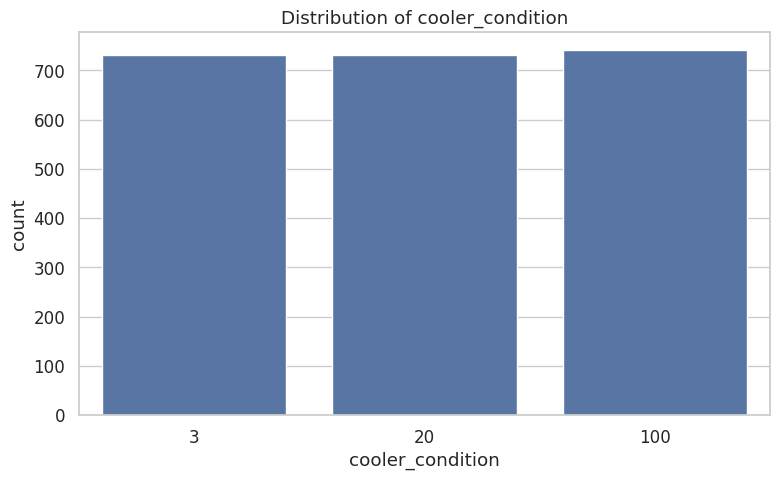

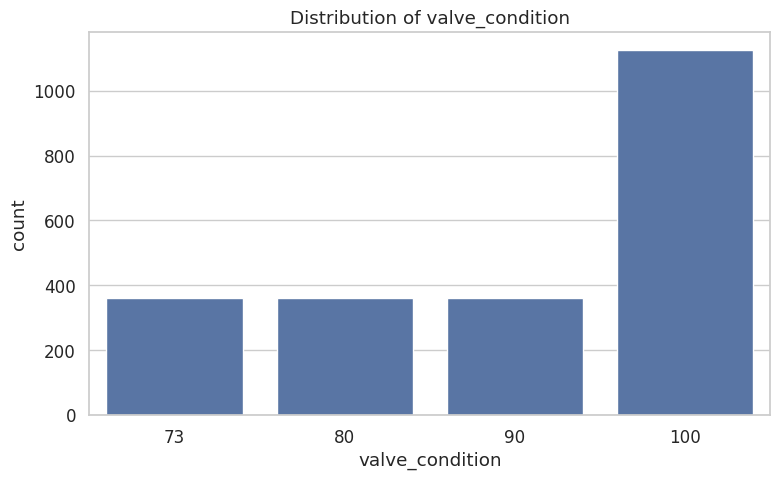

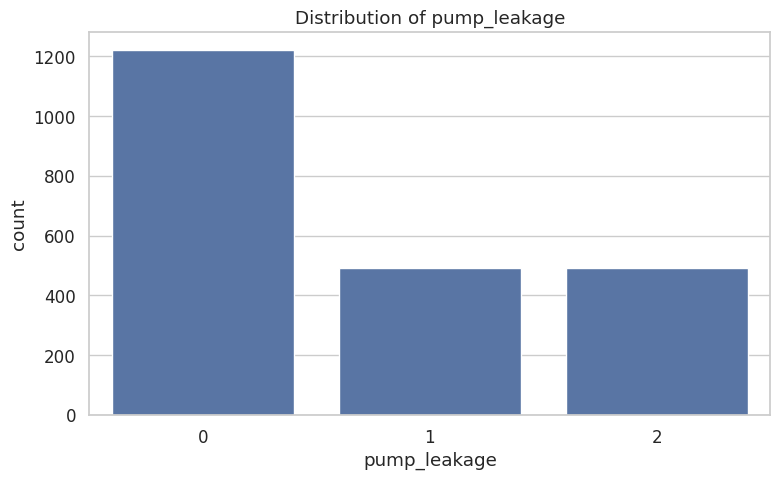

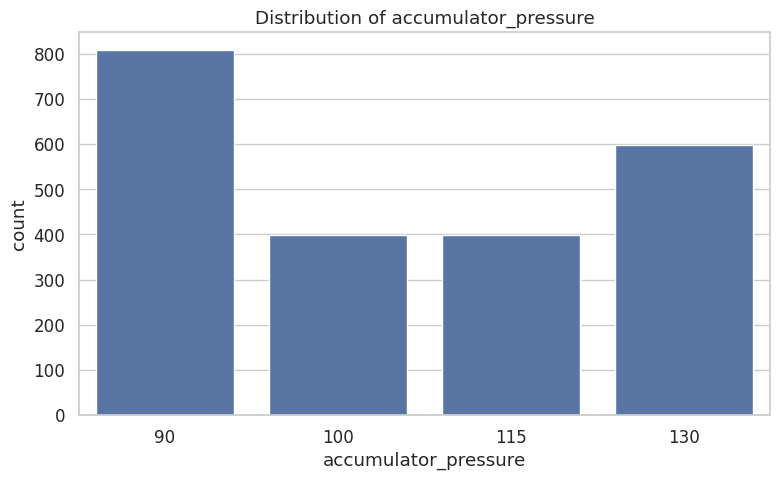

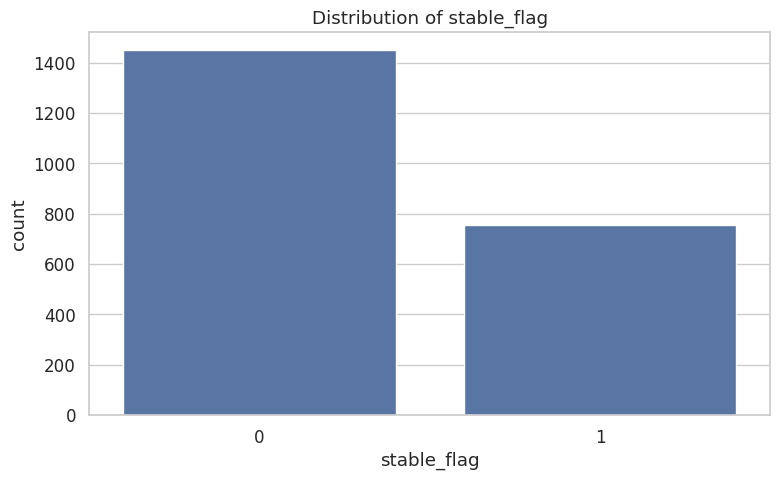

In [ ]:
# Plot target distributions
for col in y.columns:
    plt.figure()
    sns.countplot(x=y[col])
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Choose main ML target: pump leakage
target_col = "pump_leakage"
target = y[target_col]

print("Using target for main ML task:", target_col)
print(target.value_counts())

# Correlation between features and target
df_eda = pd.concat([X_summary, target], axis=1)
corr = df_eda.corr(numeric_only=True)
target_corr = corr[target_col].drop(target_col).sort_values(ascending=False)

print("Top 10 correlated features with", target_col)
display(target_corr.head(10))

Using target for main ML task: pump_leakage
pump_leakage
0    1221
2     492
1     492
Name: count, dtype: int64
Top 10 correlated features with pump_leakage


,pump_leakage
EPS1_mean,0.426320
EPS1_median,0.403787
PS2_std,0.344904
PS2_p90,0.325807
EPS1_std,0.315886
PS1_median,0.314840
PS1_mean,0.311859
PS2_mean,0.309810
PS1_std,0.306208
VS1_median,0.241048


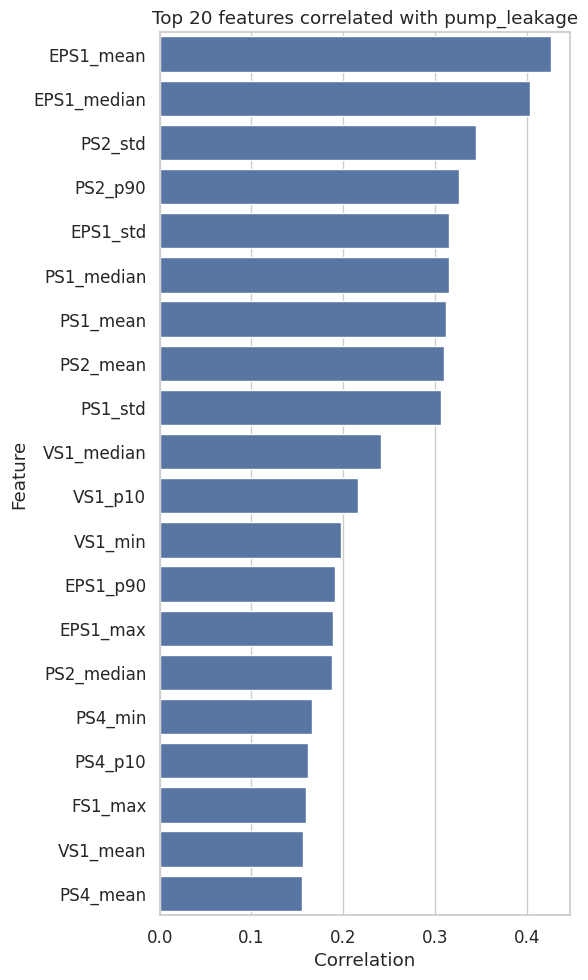

In [ ]:
# Visualize top 20 correlated features
plt.figure(figsize=(6, 10))
sns.barplot(
    x=target_corr.head(20).values,
    y=target_corr.head(20).index,
)
plt.title(f"Top 20 features correlated with {target_col}")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 6. Baseline Model – Random Forest

We train a **Random Forest** classifier on `X_summary` to predict `pump_leakage`.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_summary,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target,
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1764, 136)
Test shape: (441, 136)


In [ ]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )),
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print(f"Random Forest – Classification report for target = {target_col}")
print(classification_report(y_test, y_pred_rf))

Random Forest – Classification report for target = pump_leakage
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      0.99      0.99        99
           2       0.99      1.00      0.99        98

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



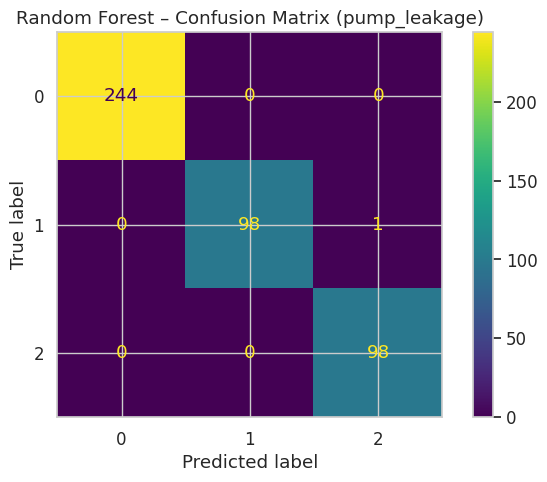

In [ ]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=np.sort(target.unique()))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=np.sort(target.unique()))
disp_rf.plot(values_format="d")
plt.title(f"Random Forest – Confusion Matrix ({target_col})")
plt.show()

## 7. Gradient Boosting with Learning Rate – XGBoost

Now we train **XGBoost**, which uses a `learning_rate` hyperparameter to control how fast it learns.


In [ ]:
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,   # <-- learning rate
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softmax" if len(np.unique(target)) > 2 else "binary:logistic",
        eval_metric="mlogloss" if len(np.unique(target)) > 2 else "logloss",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
    )),
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print(f"XGBoost – Classification report for target = {target_col}")
print(classification_report(y_test, y_pred_xgb))

XGBoost – Classification report for target = pump_leakage
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       0.99      0.98      0.98        99
           2       0.98      0.99      0.98        98

    accuracy                           0.99       441
   macro avg       0.99      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441



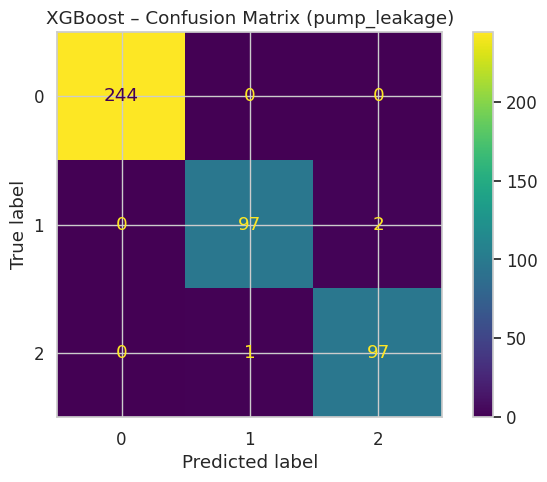

In [ ]:
# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=np.sort(target.unique()))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=np.sort(target.unique()))
disp_xgb.plot(values_format="d")
plt.title(f"XGBoost – Confusion Matrix ({target_col})")
plt.show()

In [ ]:
# Compare mean CV accuracy for RF vs XGBoost
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, n_jobs=-1)
xgb_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, n_jobs=-1)

print("Random Forest CV accuracy (mean):", rf_scores.mean())
print("XGBoost CV accuracy (mean):     ", xgb_scores.mean())

Random Forest CV accuracy (mean): 0.9965989569920165
XGBoost CV accuracy (mean):      0.996600566572238


## 8. Feature Importance & Explainability (XGBoost + SHAP)


In [ ]:
# Extract trained XGBoost model and feature names
xgb_model = xgb_pipeline.named_steps["xgb"]
feature_names = X_summary.columns

importances = xgb_model.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

display(imp_df.head(20))

,feature,importance
134,SE_p90,0.332092
132,SE_median,0.177187
60,FS1_median,0.082723
50,EPS1_min,0.025658
82,TS2_min,0.020915
107,VS1_max,0.020685
54,EPS1_p90,0.015635
5,PS1_p10,0.014443
62,FS1_p90,0.013751
74,TS1_min,0.012792


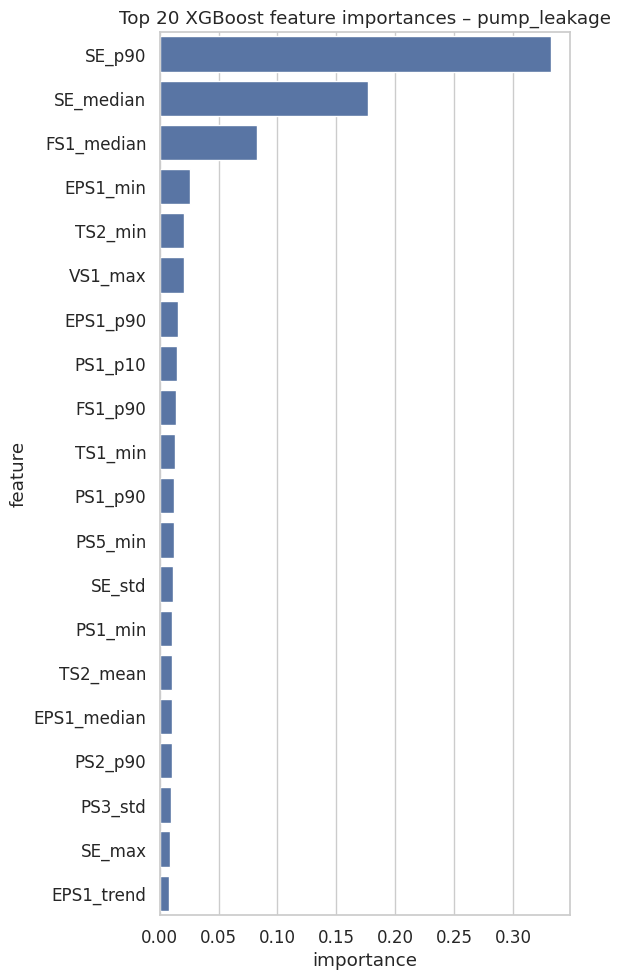

In [ ]:
# Plot top 20 important features
plt.figure(figsize=(6, 10))
sns.barplot(
    x="importance",
    y="feature",
    data=imp_df.head(20),
)
plt.title(f"Top 20 XGBoost feature importances – {target_col}")
plt.tight_layout()
plt.show()

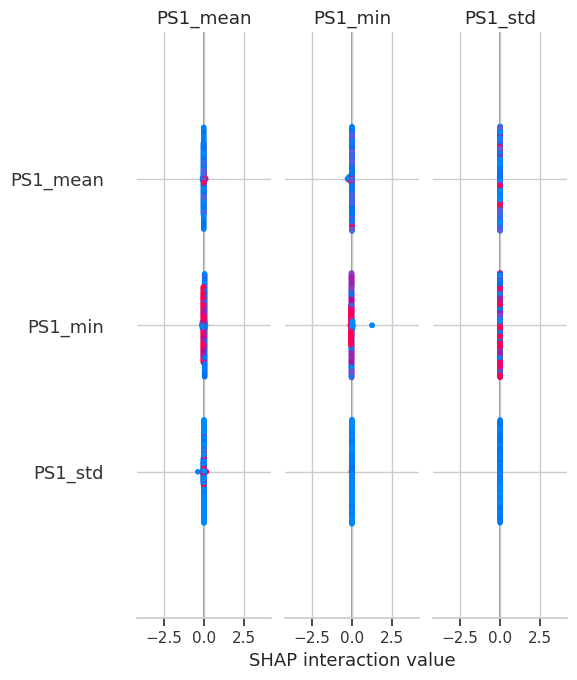

In [ ]:
# SHAP explanation on a subset of the test set (for speed)
explainer = shap.TreeExplainer(xgb_model)

X_test_scaled = xgb_pipeline.named_steps["scaler"].transform(X_test)
idx_sample = np.random.choice(len(X_test_scaled), size=min(300, len(X_test_scaled)), replace=False)
X_shap = X_test_scaled[idx_sample]

shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, feature_names=feature_names)

## 9. Extensions & Next Steps

- Try other targets: `cooler_condition`, `valve_condition`, `accumulator_pressure`, `stable_flag`.  
- Tune `learning_rate` (e.g., 0.01, 0.05, 0.1, 0.2) and compare accuracy.  
- Add more domain features (e.g., number of spikes, time above a threshold).  
- Connect predictions to maintenance actions and estimate potential savings.
